## SFINCS - grpc4bmi example

This notebook shows how the SFINCS BMI server built in this package can be used
with grpc4bmi. It assumes you have built the docker container with

```
cd src
docker build -t sfincs-bmiserver .
```

### Requirements

We use grpc4bmi to communicate with the BMI model inside a container.

In [1]:
# pip installa grpc4bmi

### Case specification

Lets use the example parameter set in https://github.com/Deltares/hydromt_sfincs/tree/main/examples/sfincs_compound

In [2]:
# !git clone https://github.com/Deltares/hydromt_sfincs/

Example above returns 0 for each time method, which is incorrect so we will use the alternate parameter set below

In [3]:
# !cp -r ~/dcache/parameter-sets/sfincs_humber ./
# !cp -r ~/ewatercycle/sfincs_humber ./

In [4]:
from pathlib import Path
parameter_set_dir = Path("sfincs_humber").absolute()
parameter_set_dir
import numpy as np

In [5]:
# see the sfincs internal data structure:
# note: the first value is the number of points (`np` in fortran code) and the length of our other arrays
indices = np.fromfile('sfincs_humber/sfincs.ind', dtype='int32')
print(len(indices))  
indices

313510


array([313509,    123,    124, ..., 803648, 803649, 803650], dtype=int32)

### Instantiate the model

This starts the model container and connects the client to it.
We can already get the component name

In [6]:
# Option 1: Build and run the container and connect to it

# from grpc4bmi.bmi_client_docker import BmiClientDocker
# model = BmiClientDocker(image='sfincs-bmiserver_tim', image_port=50051, work_dir=str(parameter_set_dir), delay=1)

# Option 2: Connect to the devcontainer directly, easy for development
# see https://github.com/eWaterCycle/sfincs-bmi-server#development-container
from grpc4bmi.bmi_grpc_client import BmiClient
import grpc
model = BmiClient(grpc.insecure_channel("localhost:50051"))

In [7]:
model.get_component_name()

'Sfincs hydrodynamic model (C)'

### Interact with the model

We can initialize the model and see that it had effect: time variables seem to be set from the input file

In [8]:
model.initialize(str(parameter_set_dir / 'sfincs.inp'))

In [9]:
model.update()

In [10]:
{
    'get_current_time': model.get_current_time(), 
    'get_start_time':model.get_start_time(),
    'get_end_time': model.get_end_time(), 
    'get_time_units': model.get_time_units(), 
    'get_time_step': model.get_time_step(),
}

{'get_current_time': 950400.0,
 'get_start_time': 950400.0,
 'get_end_time': 950400.0,
 'get_time_units': 's',
 'get_time_step': 9.999999974752427e-07}

In [11]:
# Var methods
{
    'get_input_item_count': model.get_input_item_count(),
    'get_output_item_count': model.get_output_item_count(),
    'get_input_var_names': model.get_input_var_names(),
    'get_output_var_names': model.get_output_var_names(),
    'get_var_grid': model.get_var_grid('zs'),
    'get_var_itemsize': model.get_var_itemsize('zs'),
    'get_var_nbytes': model.get_var_nbytes('zs'),
    'get_var_type': model.get_var_type('zs'),
    'get_var_units': model.get_var_units('zs'),
}

{'get_input_item_count': 6,
 'get_output_item_count': 10,
 'get_input_var_names': ('zs', 'zb', 'qsrc_1', 'qsrc_2', 'tsrc', 'zst_bnd'),
 'get_output_var_names': ('z_xz',
  'z_yz',
  'zs',
  'zb',
  'qsrc_1',
  'qsrc_2',
  'xsrc',
  'ysrc',
  'tsrc',
  'zst_bnd'),
 'get_var_grid': 0,
 'get_var_itemsize': 4,
 'get_var_nbytes': 1254036,
 'get_var_type': 'float',
 'get_var_units': 'm above reference level'}

In [12]:
{
    'get_var_grid': model.get_var_grid('qsrc_1'),
    'get_var_itemsize': model.get_var_itemsize('qsrc_1'),
    'get_var_nbytes': model.get_var_nbytes('qsrc_1'),
    'get_var_type': model.get_var_type('qsrc_1'),
    'get_var_units': model.get_var_units('qsrc_1'),
}

{'get_var_grid': 1,
 'get_var_itemsize': 4,
 'get_var_nbytes': 100,
 'get_var_type': 'float',
 'get_var_units': None}

In [13]:
# model.get_var_location('zs')
# Throws grpc4bmi erorr, maybe because enum in C and Python not matching

In [15]:
# calling multiple times gives different results
model.get_grid_shape(1, np.zeros((1), dtype=int))

array([25])

In [ ]:
# model.get_grid_x(0, np.empty(1))

In [16]:
# Grid methods
grid_id = 0
{
    'get_grid_rank': model.get_grid_rank(grid_id),
    'get_grid_size': model.get_grid_size(grid_id),
    'get_grid_type': model.get_grid_type(grid_id),
    'get_grid_shape': model.get_grid_shape(grid_id, np.empty(model.get_grid_rank(grid_id), dtype=int))
}


{'get_grid_rank': 1,
 'get_grid_size': 313509,
 'get_grid_type': 'rectilinear',
 'get_grid_shape': array([313509])}

In [17]:
shape = model.get_grid_shape(0, np.empty(1, dtype=int))
shape

array([313509])

In [18]:
# model.get_value('zs', np.zeros(shape[0], dtype=np.float32))

In [19]:
# Why is this not the same? NaN location mismatch?
data1 = model.get_value('z_xz', np.zeros(shape[0], dtype=np.float32))
data2 = model.get_value('z_xz', np.zeros(shape[0], dtype=np.float32))
np.testing.assert_allclose(data1, data2)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 33802 / 313509 (10.8%)
Max absolute difference: 46281324.
Max relative difference: inf
 x: array([-4.518404e+09,  4.565991e-41,  6.328760e+05, ...,  0.000000e+00,
        0.000000e+00,  0.000000e+00], dtype=float32)
 y: array([-4.518404e+09,  4.565991e-41, -4.564845e+07, ...,  0.000000e+00,
        0.000000e+00,  1.757296e-39], dtype=float32)

In [20]:
 model.get_grid_shape(1, np.empty(1, dtype=int))

array([25])

In [21]:
print(
    model.get_var_type('xsrc'),
    item_size := model.get_var_itemsize('xsrc'),
    total_size := model.get_var_nbytes('xsrc'),
    total_size // item_size,
)

float 4 100 25


In [25]:
model.get_value('xsrc', np.zeros(25, dtype=np.float32))

ValueError: could not broadcast input array from shape (313509,) into shape (25,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f12a9109240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f12a9109780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f12a9108fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f12a9109cc0>],
 'fliers': [],
 'means': []}

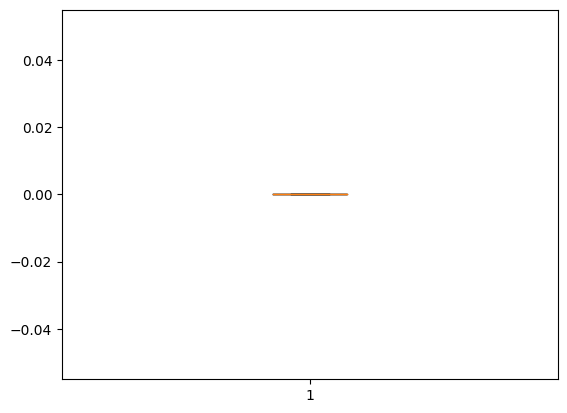

In [51]:
plt.boxplot(model.get_value('zs', np.zeros(shape[0], dtype=np.float32)), sym='')

In [17]:
model.get_value_at_indices('z_xz', np.array([0, 1, 2], dtype='int32'), np.zeros(3, dtype=np.float32))

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Socket closed"
	debug_error_string = "UNKNOWN:Error received from peer ipv6:%5B::1%5D:50051 {created_time:"2023-11-05T09:37:52.423149036+01:00", grpc_status:14, grpc_message:"Socket closed"}"
>

In [19]:
# x = model.get_grid_x(grid_id, np.empty(shape[0]))
# x
# Gives segmentation fault which kills container, probably because the size of the array is not correct

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Socket closed"
	debug_error_string = "UNKNOWN:Error received from peer ipv6:%5B::1%5D:50051 {created_time:"2023-11-05T08:54:15.911660222+01:00", grpc_status:14, grpc_message:"Socket closed"}"
>

In [18]:
model.get_current_time()
model.update_until(10.)
model.get_current_time()


950410.499130249

In [19]:
 model.get_grid_y(grid_id, np.empty(shape[0], dtype=float))

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Socket closed"
	debug_error_string = "UNKNOWN:Error received from peer ipv6:%5B::1%5D:50051 {grpc_message:"Socket closed", grpc_status:14, created_time:"2023-11-05T08:52:28.479373782+01:00"}"
>

In [ ]:
# water level
model.get_value('zs', np.zeros(886*908))
# model.get_value('zs', np.zeros(shape[0]))

In [ ]:
for i in range(10):
    print(model.get_current_time())
    model.update()
    

In [ ]:
shape = model.get_grid_shape(0, np.empty(2, dtype=int))
model.get_value('zs', np.zeros(shape[0]))

In [ ]:
model.set_value('zs', np.zeros(shape[0]))
